# Exercise 7: Sinusoidal plus residual model

In this exercise you will analyze and synthesize sounds using the Harmonic plus Stochastic (HPS) model, `hpsModel.py`. There are two questions in this exercise. In the first one you will analyze a speech sound that we give and in the second one you will analyze a sound of your choice, in both cases using the HPS model. For each question, you will first describe some of the sound characteristics by listening to the sounds and visualizing their spectrogram, characteristics that should be of relevance for the analysis/synthesis with the HPS model. Then from the described characteristics you will set the appropriate values for the different analysis parameters, explaining the choices you make, and analyze and synthesize the sounds with the HPS model software.

For this exercise, you can use `models_GUI.py`, to experiment with the parameters easily and then use them in here. Feel free to modify the code of the model if needed and add it also here. 

To help you with the exercise, we first give a brief description of the analysis parameters used by the HPS model function:

1. Window type (`window`) and Window size (`M`): The choice of window size and window type has a time-frequency trade-off. Choosing a longer window helps resolve sinusoidal components that are close in frequency, but gives a poorer temporal resolution. Shorter windows track transients better, maintaining sharp onsets, but may not resolve frequency components so well. For monophonic harmonic sounds, the window size is best chosen based on the lowest value of f0 and the fastest change in pitch.
2. FFT size (`N`): The FFT size is chosen as a power of 2 larger than the window size M. A large FFT size N, compared with M, results on an interpolated DFT spectrum and leads to better estimation of spectral peak values. However, given that the software also uses parabolic interpolation we can achieve good peak estimates with not too big FFT sizes, for example just the next power of 2 larger than M.
3. Threshold in negative dB (`t`): The peak picking threshold is the lowest amplitude peak that will be identified. Setting a very low threshold ($<-120$dB) will take most peaks, but the threshold should be set as high as possible to minimize the presence of peaks that do not correspond to sinusoidal peaks (the window main-lobe).
4. Maximum number of harmonics (`nH`): The maximum number of harmonics that can be detected in a harmonic sound is influenced by the brightness of the sound, but also by the sampling rate and by how low is the f0. The recording quality can also have an impact. For a compact representation, we should only capture the relevant harmonics, the ones that affect the perceptual quality of the reconstruction.
5. Minimum f0 frequency in Hz (`minf0`) and Maximum f0 frequency in Hz (`maxf0`): The `minf0` and `maxf0` are the parameters used by the fundamental frequency detection algorithm to obtain possible `f0` candidates to be passed to the TWM algorithm. Choosing a correct range of `f0`, but the smallest possible, greatly improves the `f0` estimation by TWM algorithm, specially minimizing octave errors, which are very common in `f0` detection algorithms. You should select the values by first looking at the spectrogram of the sound and identifying the lowest and highest fundamental frequencies present.
6.  Threshold in the f0 detection (`f0et`): This is the maximum error allowed in the TWM algorithm. If the value is too large, the algorithm might detect fundamental frequencies that might not be actually so. Instead, if is it too small, good fundamental frequencies might not be detected, returning value 0 at that frame. The smaller the value the more restrictive the algorithm behaves. A normal strategy is to start with a big value ($> 10$) and then making it smaller until we only keep what we consider to be the relevant f0 components, discarding the \texttt{f0} values in the parts of the sound that do not have a clear harmonic structure.
7. Slope of harmonic deviation (`harmDevSlope`): Slope of the harmonic deviation allowed in the estimated harmonic frequencies, compared to a perfect harmonic frequencies. If the value is 0 it means that we allow the same deviation for all harmonics, which is hard coded to \texttt{f0}$/3$. A value bigger than 0 means that higher harmonics will be allowed to deviate more than the lower harmonics from perfect harmonicity (which is a common behaviour). It normally works better to have a value slightly bigger than 0, for example around 0.01.
8. Minimum length of harmonics (`minSineDur`): Any harmonic track shorter, in seconds, than minSineDur will be removed. This is a good parameter for discarding harmonic tracks that are too short and thus that do not correspond to stable harmonics of the sound. Typically we put a value bigger that 0.02 seconds.
9. Decimation factor of magnitude spectrum for stochastic analysis (`stocf`): The stochastic approximation of the residual is a decimated version of the magnitude spectrum of the residual. This leads to a compact and smooth function that approximates the magnitude spectrum of the residual at each frame. The smaller the stocf, higher the decimation will be and thus will result in a more compact representation. A value of 1 means no decimation, leaving the residual magnitude spectrum as it is. A value of 0.2 (a good starting value) will decimate the original residual magnitude spectrum by a factor of 1/5.

The most compact and useful representation of a sound, least number of analysis data values while maintaining the sound quality in the synthesis, will be obtained by using a high t, a small `nH`, a small decimation factor for stochastic analysis, stocf, and by succeeding in detecting only the harmonics they are perceptually relevant. The values of `nH`, `minf0` and `maxf0` should be chosen by first visualizing the spectrogram of the sound with a large enough window size. There is usually a range of all parameter values for which we get a good reconstruction. Also the analysis parameters are not independent of each other and hence they need to be considered together. For testing if the detection of the harmonics have been done correctly (and for improving it) it is very useful to perform the Harmonic plus Residual analysis/synthesis (HPR model) using the same parameters and listen to the residual component for possible artifacts resulting from the harmonic analysis.

## Part 1. Obtain a good harmonic+stochastic analysis of a speech sound

Analyze and synthesize the `sound speech-female.wav`, available from the sounds directory, using `hpsModelAnal()` and `hpsModelSynth()` from the `hpsModel.py` module. The goal is to obtain the best possible reconstruction using the most compact representation. Perform the following two tasks:

1. Analyze the sound with the STFT using `models-GUI.py`, or with any other analysis tool you might wish, and describe the characteristics of the sound that might be relevant to perform the HPS analysis. Specially important characteristics for the analysis include pitch range and maximum number of harmonics. Explain the sound: write no more than a paragraph for this description.
2. Select the analysis parameters that give a good reconstruction and at the same time result in the most compact representation possible, specially related to the number of harmonics and the number of stochastic coefficients. We recommend that you first perform the harmonic plus residual analysis and by listening to the residual make some decisions on the best parameters to use. You can listen to the output sounds (harmonic, residual, stochastic components) and fine tune the parameters. Save the output sounds. Explain the choices for the following parameters: window type, window size, FFT size, minimum f0, _maximum f0, error threshold in f0 detection, number of harmonics, and stochastic decimation factor. Explain the analysis: in your descriptions do not use more than one sentence per parameter.

__Example:__ example of an analysis/synthesis for a male speech sound:

1. Input sound: http://freesound.org/people/xserra/sounds/317744/
2. Harmonic component: http://freesound.org/people/xserra/sounds/327139/
3. Residual component: http://freesound.org/people/xserra/sounds/327141/
4. Stochastic component: http://freesound.org/people/xserra/sounds/327137/
5. Harmonic+stochastic resynthesis: http://freesound.org/people/xserra/sounds/327140/


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
import sys, os
sys.path.append('../software/models/')
import utilFunctions as UF
import stft as STFT
import hpsModel as HPS
import IPython.display as ipd

Text(0.5, 1.0, 'magnitude spectrogram')

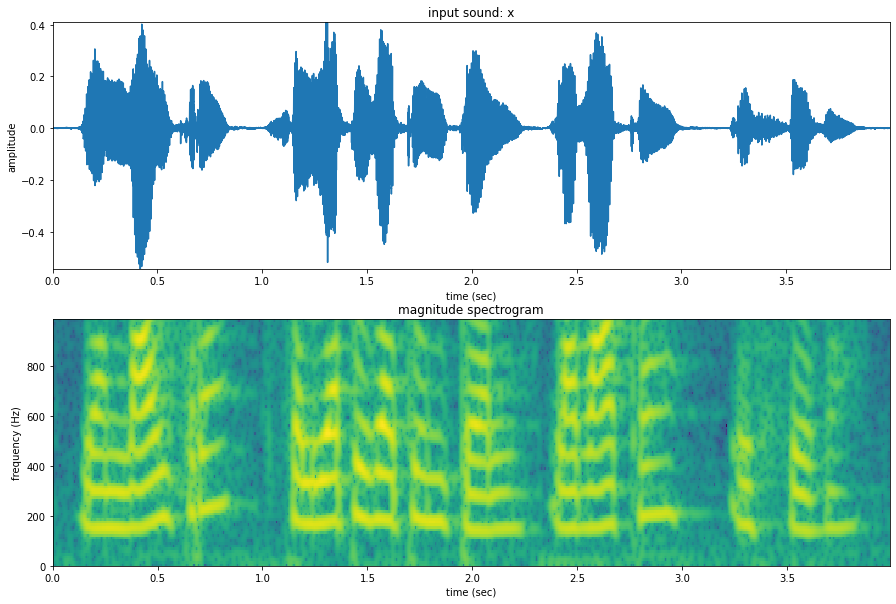

In [2]:
# E7 - 1.1: Set STFT analysis parameters and visualize spectrogram of speech-female.wav sound

input_file = '../sounds/speech-female.wav'

### set parameters

# blackman window in order to clearly identify the F0 and the rest of the harmonics
window = 'blackman'
# for a propper analysis a window size of at least fs/F0*#bins(blackman) is required. 
# In this case, 44100/140 * 6 ~ 1890, but I will use a x2 factor in order to increase the frequency
# resulution. + 1 in order to obtain a odd number
M = 1400 * 2 + 1
# closest power of 2
N = 4096
# hop size small enough to have good time resolution
H = 256

    
# no need to modify anything after this
fs, x = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
mX, pX = STFT.stftAnal(x, w, N, H)

ipd.display(ipd.Audio(data=x, rate=fs))

plt.figure(figsize=(15, 10))
maxplotfreq = 1000.0

# plot input sound
plt.subplot(2,1,1)
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), min(x), max(x)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('input sound: x')

# plot magnitude spectrogram
plt.subplot(2,1,2)
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')

In [3]:
# E7 - 1.2: Perform Harmonic plus Stochastic analysis and synthesis of speech-female.wav sound

input_file = '../sounds/speech-female.wav'

### fill the parameters
window ='hamming'
M = 1401
N = 2048
t = -100
minSineDur = 0.1
nH = 40
minf0 = 135
maxf0 = 245
f0et = 7
harmDevSlope = 0.07
stocf = 0.2

# no need to modify anything after this
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

In [4]:
# E7 - 1.3: Explain the HPS analysis parameters used
'''
The sound has it's lower F0 frequency at around 140Hz and the highest around 230Hz. The shortest syllable
is about 0.08 seconds length. This is important as this could be used as the smalles "note" that the harmonic
model should identify. The number of harmonics appear to be a lot, but after 1KHz their magnitude
starts to decrease.

Given this information, the choosen parameters are:
window ='hamming': This is the default window for speech synthesis

M = 1401: small enough so it does not mess with the transients, but large enough so 
the fs/F0*#bin(hamming) = 1260  rule is followed. Then the closes k * 100 + 1 value is chosen 

N = 2048: closest power of 2

t = -100: threshold to allow the quiests syllables be identified

minSineDur = 0.1: smallest syllable identifies ( 80 mili seconds) + margin
nH = 40: try/error + analysis of the spectrogram strategy. 40 harmonics gave me the bests results 
without sacrifying the high end

minf0 = 135: Minimum F0 identifyied was 140Hz - margin

maxf0 = 245: Max F0 identifyed was 220Hz + margin

f0et = 7: try/error strategy to obtain the best HPS synthesis

harmDevSlope = 0.07: try/error strategy to obtain the best HPS synthesis

stocf = 0.2: try/error strategy to obtain the best HPS synthesis. The higher, the more frequency filters
are created, but it also has the tradeoff of a heavier stochastic representation.
'''

'\nThe sound has it\'s lower F0 frequency at around 140Hz and the highest around 230Hz. The shortest syllable\nis about 0.08 seconds length. This is important as this could be used as the smalles "note" that the harmonic\nmodel should identify. The number of harmonics appear to be a lot, but after 1KHz their magnitude\nstarts to decrease.\n\nGiven this information, the choosen parameters are:\nwindow =\'hamming\': This is the default window for speech synthesis\n\nM = 1401: small enough so it does not mess with the transients, but large enough so \nthe fs/F0*#bin(hamming) = 1260  rule is followed. Then the closes k * 100 + 1 value is chosen \n\nN = 2048: closest power of 2\n\nt = -100: threshold to allow the quiests syllables be identified\n\nminSineDur = 0.1: smallest syllable identifies ( 80 mili seconds) + margin\nnH = 40: try/error + analysis of the spectrogram strategy. 40 harmonics gave me the bests results \nwithout sacrifying the high end\n\nminf0 = 135: Minimum F0 identifyied 

## Part 2. Obtain a good harmonic+stochastic analysis of a monophonic musical phrase

Analyze and synthesize a harmonic sound of your choice from Freesound using the harmonic plus stochastic model. The goal is to obtain the best possible reconstruction using the most compact representation possible. Return an explanation of what you have done and why, together with the re-synthesized sounds.

The sound from freesound to use could be in any format, but to use the sms-tools software you will have to first convert it to be a monophonic file (one channel), sampling rate of 44100, and 16bits samples. You might also have to select a fragment of the sound.

_Part 2.1:_ Choose a sound from freesound to be analyzed, download it, and if necessary, edit it, and covert it to the right format. It should be a short monophonic musical fragment of a harmonic sound, not longer than 5 seconds. In the explanation add the freesound link of the sound selected and write a brief explanation of why you chose this sound.

_Part 2.2:_ Analyze the chosen sound with the STFT, or with any other analysis or tool you might wish, and describe the characteristics of the sound that will be relevant to perform the harmonic plus stochastic analysis. Important characteristics for the analysis include the pitch range and the maximum number of harmonics. Write no more than a paragraph.

_Part 2.3:_ Select the analysis parameters that give a good reconstruction and at the same time result in to the most compact representation, specially related to the number of harmonic and the number of stochastic coefficients. We recommend that you first perform the harmonic plus residual analysis and by listening to the residual make some decisions on the best parameters to use. You can listen to the output sounds (harmonic, residual, stochastic components) and fine tune the parameters. Save the output sounds. Explain the choices for the following parameters: window type, window size, FFT size, minimum f0, maximum f0, error threshold in f0 detection, number of harmonics, and stochastic decimation factor. In your descriptions do not use more than one sentence per parameter.

In [5]:
# E7 - 2.1: download a sound from freesound, read it with waveread, and describe it

#### your code here
input_file = 'throat.wav'
(fs, x) = UF.wavread(input_file)
ipd.display(ipd.Audio(data=x, rate=fs))

### write a brief description of the sound
"""
This is a 5 seconds excerpt of a male doing throat singing. Throat singing is a technique that
consists in distort the vocal strings and change the mouth shape in order to modulate in amplitude the 
higher frequencies of the sound. In some way, the mouth works as a resonator filter.

I thoght this sound was going to be interesting to analyze, given that the harmonics changes its intensity

The sound was obtained from freesound https://freesound.org/people/djgriffin/sounds/22023/ then cropped and
exported in Audacity

"""

'\nThis is a 5 seconds excerpt of a male doing throat singing. Throat singing is a technique that\nconsists in distort the vocal strings and change the mouth shape in order to modulate in amplitude the \nhigher frequencies of the sound. In some way, the mouth works as a resonator filter.\n\nI thoght this sound was going to be interesting to analyze, given that the harmonics changes its intensity\n\nThe sound was obtained from freesound https://freesound.org/people/djgriffin/sounds/22023/ then cropped and\nexported in Audacity\n\n'

'\nthis excerpt presents a base tone being maintained and some harmonics that appers to be moving. \nIf we want to be more specific, what is going on is that some harmonics appears and then dissapears as the\nmouth modulates the sound.\nGiven these characteristics, the minimum F0 is the same than the maximum, around 85Hz.\n'

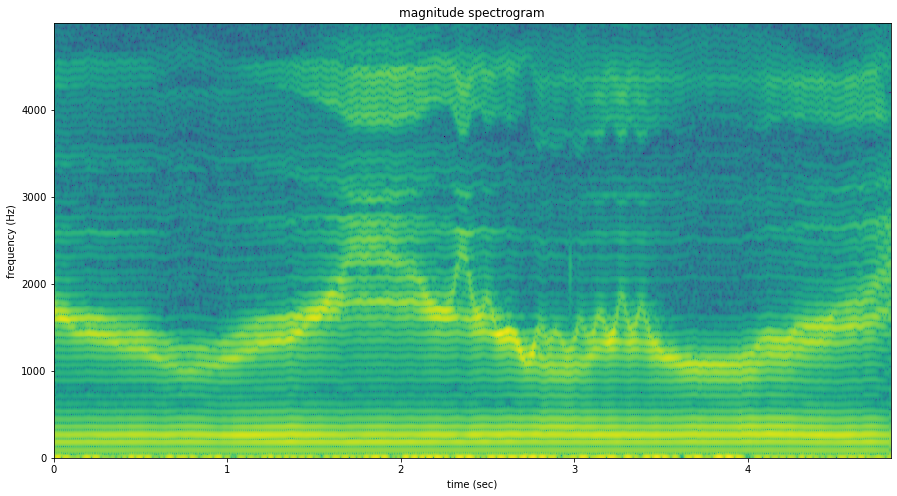

In [6]:
# E7 - 2.2: Set STFT analysis parameters and visualize spectrogram of chosen sound. Explain relevant sound 
# characteristics for HPS model

### basic visualization and listening of sound
input_file = 'throat.wav'
window = 'blackmanharris'
M = 2047
N = 4096
H = 256

# no need to modify anything after here
fs, x = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
mX, pX = STFT.stftAnal(x, w, N, H)

ipd.display(ipd.Audio(data=x, rate=fs))

plt.figure(figsize=(15, 8))
maxplotfreq = 5000.0
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')

### describe the characteristics relevant to perform the harmonic plus stochastic analysis
"""
this excerpt presents a base tone being maintained and some harmonics that appers to be moving. 
If we want to be more specific, what is going on is that some harmonics appears and then dissapears as the
mouth modulates the sound.
Given these characteristics, the minimum F0 is the same than the maximum, around 85Hz.
"""


In [7]:
# E7 - 2.3: Perform Harmonic plus Stochastic analysis and synthesis of chosen sound


### fill the parameters
input_file = 'throat.wav'
window ='hamming'
M = 2001
N = 4096
t = -70
minSineDur = 4
nH = 20
minf0 = 80
maxf0 = 95
f0et = 7
harmDevSlope = 0.7
stocf = 0.3

# No need to modify
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

In [8]:

# E7 - 2.4: Explain the choices of HPS analysis parameters
'''


window ='hamming': this is the default window for speech analysis. This is not speech, but is a 
mouth-generated sound.

M = 2001: we need at least 44100/90*4 ~ 1960 the next k * 100 + 1 is 2001.

N = 4096: closest power of 2. But a zero padding interpolation in needed.

t = -70: : threshold to allow the quiests harmonics variation be identified

minSineDur = 4: since the model identifies the harmonics with a harmDevSlope, A small value works well in
order that the model identifies the variation of the frequencies in amplitude as a single harmonic with
a high frequenfcy variation.

nH = 20: try/error + analysis of the spectrogram strategy. 20 harmonics gave me the bests results 
without sacrifying the high end

minf0 = 80: Minimum F0 identifyied was 85Hz - margin

maxf0 = 95: Maximum F0 identifyied was 85Hz + margin

f0et = 7: try/error strategy to obtain the best HPS synthesis

harmDevSlope = 0.7: try/error strategy to obtain the best HPS synthesis

stocf = 0.3: try/error strategy to obtain the best HPS synthesis. The higher, the more frequency filters

are created, but it also has the tradeoff of a heavier stochastic representation.
'''

"\n\n\nwindow ='hamming': this is the default window for speech analysis. This is not speech, but is a \nmouth-generated sound.\n\nM = 2001: we need at least 44100/90*4 ~ 1960 the next k * 100 + 1 is 2001.\n\nN = 4096: closest power of 2. But a zero padding interpolation in needed.\n\nt = -70: : threshold to allow the quiests harmonics variation be identified\n\nminSineDur = 4: since the model identifies the harmonics with a harmDevSlope, A small value works well in\norder that the model identifies the variation of the frequencies in amplitude as a single harmonic with\na high frequenfcy variation.\n\nnH = 20: try/error + analysis of the spectrogram strategy. 20 harmonics gave me the bests results \nwithout sacrifying the high end\n\nminf0 = 80: Minimum F0 identifyied was 85Hz - margin\n\nmaxf0 = 95: Maximum F0 identifyied was 85Hz + margin\n\nf0et = 7: try/error strategy to obtain the best HPS synthesis\n\nharmDevSlope = 0.7: try/error strategy to obtain the best HPS synthesis\n\nstoc